In [1]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

from grow.dgca import DGCA
from grow.runner import Runner
from grow.reservoir import Reservoir, get_seed
from evolve.mga import ChromosomalMGA, Chromosome, EvolvableDGCA
from evolve.fitness import TaskFitness, MetricFitness
from measure.tasks import narmax, santa_fe

# Set random seed for reproducibility
np.random.seed(2040)

## 1. Basic DGCA Growth Example

Let's start by creating a simple DGCA model and watch it grow a graph from a single seed node.

In [2]:
# Create a seed reservoir (starting point)
n_states = 3  # Number of possible node states
seed = get_seed(input_nodes=7, output_nodes=0, n_states=n_states)

print(f"Initial seed: {seed}")
print(f"Initial size: {seed.size()} nodes")
print(f"Initial edges: {seed.num_edges()}")

# Create a DGCA model with random weights
dgca = DGCA(n_states=n_states, hidden_size=64, noise=0)

# Create a runner to manage the growth process
runner = Runner(max_steps=50, max_size=200)

# Grow the graph!
final_reservoir = runner.run(dgca, seed)

print(f"\nFinal reservoir: {final_reservoir}")
print(f"Growth status: {runner.status}")
print(f"Steps taken: {len(runner.graphs)}")

Initial seed: Graph with 8 nodes and 7 edges
Initial size: 8 nodes
Initial edges: 7

Final reservoir: Graph with 124 nodes and 1046.0 edges
Growth status: max_size
Steps taken: 6


## 2. Visualizing the Grown Graph

Let's visualize some of the graphs generated during the growth process.

Visualizing 4 snapshots of the growth process...

Snapshot 1 (Step 0):
  Nodes: 8, Edges: 7, Connectivity: 0.1094


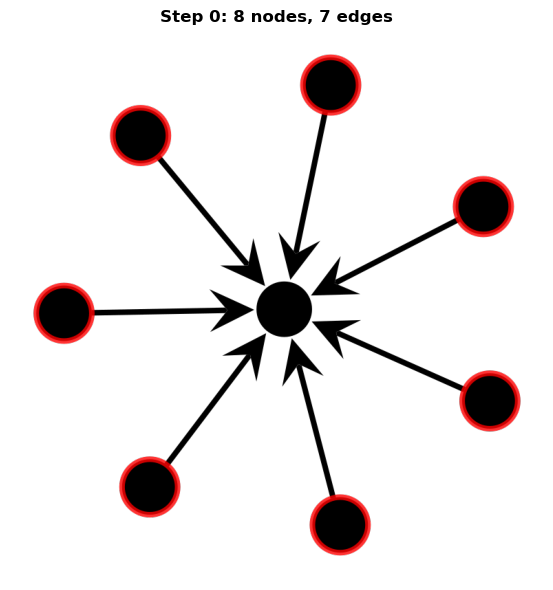


Snapshot 2 (Step 1):
  Nodes: 16, Edges: 28.0, Connectivity: 0.1094


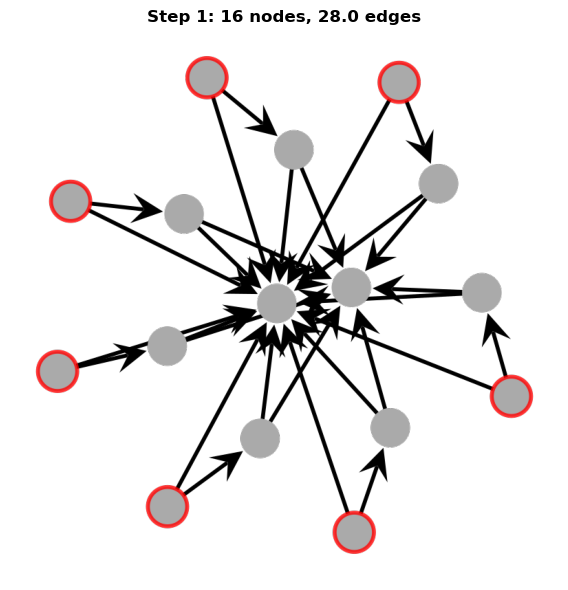


Snapshot 3 (Step 3):
  Nodes: 62, Edges: 328.0, Connectivity: 0.0853


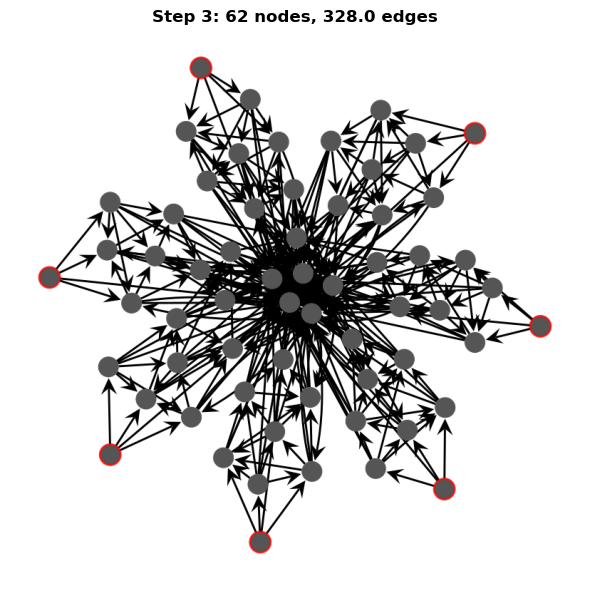


Snapshot 4 (Step 5):
  Nodes: 247, Edges: 3174.0, Connectivity: 0.0520


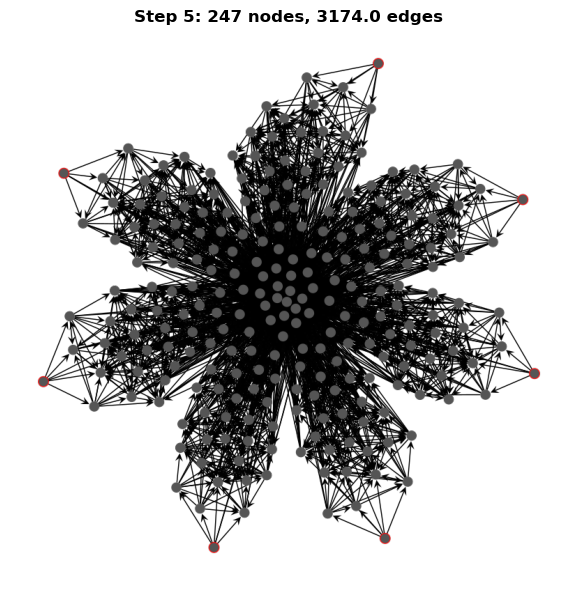

In [4]:
# Select a few snapshots to visualize
n_snapshots = min(4, len(runner.graphs))
snapshot_indices = np.linspace(0, len(runner.graphs)-1, n_snapshots, dtype=int)

print(f"Visualizing {n_snapshots} snapshots of the growth process...\n")

for idx, ax_idx in enumerate(snapshot_indices):
    res = runner.graphs[ax_idx]
    
    print(f"Snapshot {idx+1} (Step {ax_idx}):")
    print(f"  Nodes: {res.size()}, Edges: {res.num_edges()}, Connectivity: {res.connectivity():.4f}")
    
    # Visualize the graph using graph-tool
    if res.size() > 0:
        try:
            # Save to file then display
            filename = f"snapshot_{ax_idx}.png"
            res.draw_gt(output=filename, output_size=(400, 400))
            
            # Display the saved image
            img = plt.imread(filename)
            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Step {ax_idx}: {res.size()} nodes, {res.num_edges()} edges", 
                        fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Clean up temporary file
            import os
            if os.path.exists(filename):
                os.remove(filename)
        except Exception as e:
            print(f"  Error rendering: {str(e)}")
    else:
        print(f"  Graph is empty - nothing to visualize")
    print()

## 3. Training a Reservoir on NARMA Task

Now let's see how a grown reservoir can be used for time-series prediction using the NARMA (Nonlinear AutoRegressive Moving Average) task.

In [5]:
# Set random seed for reproducibility
np.random.seed(2040)

In [6]:
# Use the final reservoir from section 1 for the NARMA task
# Convert it to bipolar weights for better reservoir computing performance
reservoir_for_task = final_reservoir.bipolar()

print(f"Using reservoir from section 1 for NARMA task:")
print(f"  Size: {reservoir_for_task.size()} nodes")
print(f"  Edges: {reservoir_for_task.num_edges()}")
print(f"  Connectivity: {reservoir_for_task.connectivity():.4f}")
print(f"  Largest component: {reservoir_for_task.get_largest_component_frac():.2%}")

Using reservoir from section 1 for NARMA task:
  Size: 124 nodes
  Edges: 1046.0
  Connectivity: 0.0680
  Largest component: 100.00%


NARMA task data generated:
  Input shape: (1, 2000)
  Target shape: (1, 2000)

Training complete!
NMSE (lower is better): 0.5716

Training complete!
NMSE (lower is better): 0.5716


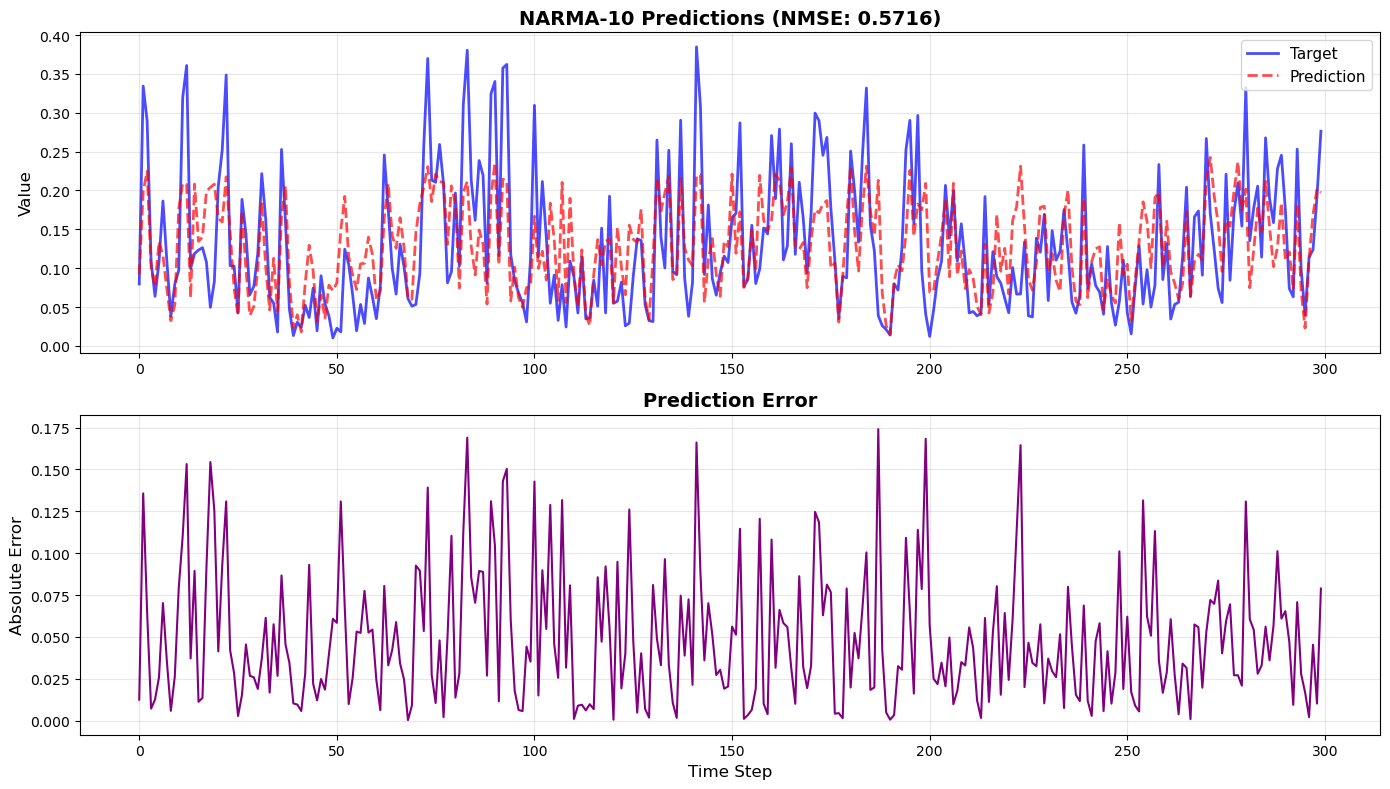

In [7]:
# Generate NARMA-10 task data
input_seq, target_seq = narmax(order=10, num_timesteps=2000)

print(f"NARMA task data generated:")
print(f"  Input shape: {input_seq.shape}")
print(f"  Target shape: {target_seq.shape}")

# Train the reservoir on the NARMA task
reservoir_for_task.reset()
predictions = reservoir_for_task.train(input_seq, target=target_seq)

# Calculate NMSE (Normalized Mean Squared Error)
washout = reservoir_for_task.washout
nmse = np.mean((target_seq[:, washout:] - predictions) ** 2) / np.var(target_seq[:, washout:])

print(f"\nTraining complete!")
print(f"NMSE (lower is better): {nmse:.4f}")

# Visualize predictions vs targets
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

time_window = 300
start_idx = washout
end_idx = start_idx + time_window

# Plot predictions vs target
ax1.plot(target_seq[0, start_idx:end_idx], linewidth=2, label='Target', color='blue', alpha=0.7)
ax1.plot(predictions[0, :time_window], linewidth=2, label='Prediction', color='red', alpha=0.7, linestyle='--')
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title(f'NARMA-10 Predictions (NMSE: {nmse:.4f})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot error over time
error = np.abs(target_seq[0, start_idx:end_idx] - predictions[0, :time_window])
ax2.plot(error, linewidth=1.5, color='purple')
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Prediction Error', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Evolutionary Training of DGCA

The key innovation is using evolution to optimize the DGCA's MLPs to grow reservoirs that perform well on tasks. Let's run a short evolutionary training session.

In [8]:
np.random.seed(2040)

In [9]:
# Setup evolutionary parameters (fast configuration for quick demo)
args = SimpleNamespace(
    pop_size=4,              # Small population for faster evolution
    mutate_rate=0.05,        # Higher mutation for faster exploration
    cross_rate=0.5,          # Crossover rate
    cross_style='cols',      # Crossover style
    n_trials=20,             # Fewer trials for quick demo (normally 1000+)
    input_nodes=0,           # Just 1 starting input node for simplicity
    output_nodes=0,          
    noise=0.1,               # Some noise
    order=10,                # NARMA-10
    task='narma',            # Use NARMA task
    max_size=75,             # Smaller max size for faster growth
    metric=None,
    n_states=3,              # 3 possible node states
    output_dir='demo_results',
    heavy_log=False,
    n_reps_if_noisy=1        # Only 1 rep since noise=0
)

# Define fitness constraints
conditions = {
    "max_size": args.max_size,
    "min_size": args.input_nodes + args.output_nodes + (10 if not args.order else args.order),
}

# Create fitness function
fitness_fn = TaskFitness(
    series=narmax,
    conditions=conditions,
    verbose=False,
    order=args.order,
    fixed_series=True,
)

print("Fitness function created!")
print(f"Task: NARMA-{args.order}")
print(f"Reservoir constraints: min_size={conditions['min_size']}, max_size={conditions['max_size']}")

Fitness function created!
Task: NARMA-10
Reservoir constraints: min_size=10, max_size=75


In [10]:
# Create the evolutionary setup
seed_reservoir = get_seed(args.input_nodes, args.output_nodes, args.n_states)
evolvable_model = EvolvableDGCA(n_states=args.n_states, hidden_size=32, noise=args.noise)  # Smaller hidden size
runner_evo = Runner(max_steps=10, max_size=50)  # Fewer steps and smaller max size for faster growth

mga = ChromosomalMGA(
    popsize=args.pop_size,
    seed_graph=seed_reservoir,
    model=evolvable_model,
    runner=runner_evo,
    fitness_fn=fitness_fn,
    mutate_rate=args.mutate_rate,
    cross_rate=args.cross_rate,
    cross_style=args.cross_style,
    run_id=1,
    n_trials=args.n_trials,
    output_dir=args.output_dir,
    heavy_log=args.heavy_log,
    n_reps_if_noisy=args.n_reps_if_noisy
)

print("\nEvolutionary algorithm initialized!")
print(f"Population size: {args.pop_size}")
print(f"Number of contests: {args.n_trials}")
print(f"Mutation rate: {args.mutate_rate}")
print(f"Crossover rate: {args.cross_rate}")

[run 1] Best-of-run results will be stored in: demo_results/best_run_1.json

Evolutionary algorithm initialized!
Population size: 4
Number of contests: 20
Mutation rate: 0.05
Crossover rate: 0.5


In [11]:
# Run evolution with progress bar
print("\nStarting evolution...\n")
mga.run(progress=True)

print("\n\nEvolution complete!")
print(f"Best fitness achieved: {mga.best['avg_fitness']:.6f}")
print(f"Results saved to: {mga.results_file}")


Starting evolution...



  5%|▌         | 1/20 [00:04<01:28,  4.64s/it, fit=0.998, best=0.998]

[run 1] epoch=0 avg_fit=0.9979653108024195 best_avg=0.9979653108024195


 10%|█         | 2/20 [00:09<01:23,  4.65s/it, fit=0.998, best=0.998]

[run 1] epoch=1 avg_fit=0.997964216660803 best_avg=0.997964216660803
[run 1] epoch=2 avg_fit=0.9979648167872572 best_avg=0.997964216660803
[run 1] epoch=2 avg_fit=0.9979648167872572 best_avg=0.997964216660803


 20%|██        | 4/20 [00:27<02:02,  7.67s/it, fit=0.532, best=0.532]

[run 1] epoch=3 avg_fit=0.531981691374676 best_avg=0.531981691374676


 25%|██▌       | 5/20 [00:31<01:33,  6.23s/it, fit=0.998, best=0.532]

[run 1] epoch=4 avg_fit=0.9979628380598239 best_avg=0.531981691374676
[run 1] epoch=5 avg_fit=0.4938473228341681 best_avg=0.4938473228341681
[run 1] epoch=5 avg_fit=0.4938473228341681 best_avg=0.4938473228341681


 30%|███       | 6/20 [00:39<01:33,  6.69s/it, fit=0.494, best=0.494]

[run 1] epoch=5 avg_fit=0.9979658551571886 best_avg=0.4938473228341681
[run 1] epoch=6 avg_fit=0.5352349083939573 best_avg=0.4938473228341681
[run 1] epoch=6 avg_fit=0.5352349083939573 best_avg=0.4938473228341681


 35%|███▌      | 7/20 [00:47<01:36,  7.43s/it, fit=0.443, best=0.443]

[run 1] epoch=6 avg_fit=0.44311615787267156 best_avg=0.44311615787267156
[run 1] epoch=7 avg_fit=0.4859579493656284 best_avg=0.44311615787267156
[run 1] epoch=7 avg_fit=0.4859579493656284 best_avg=0.44311615787267156


 40%|████      | 8/20 [00:56<01:34,  7.88s/it, fit=0.486, best=0.443]

[run 1] epoch=8 avg_fit=0.9979627842054963 best_avg=0.44311615787267156


 50%|█████     | 10/20 [01:13<01:20,  8.02s/it, fit=0.998, best=0.443]

[run 1] epoch=9 avg_fit=0.9979631709965459 best_avg=0.44311615787267156
[run 1] epoch=10 avg_fit=0.46710739644854654 best_avg=0.44311615787267156
[run 1] epoch=10 avg_fit=0.46710739644854654 best_avg=0.44311615787267156


 55%|█████▌    | 11/20 [01:21<01:12,  8.07s/it, fit=0.467, best=0.443]

[run 1] epoch=10 avg_fit=0.9979644705086379 best_avg=0.44311615787267156
[run 1] epoch=11 avg_fit=0.47537245252777527 best_avg=0.44311615787267156
[run 1] epoch=11 avg_fit=0.47537245252777527 best_avg=0.44311615787267156


 65%|██████▌   | 13/20 [01:40<01:01,  8.73s/it, fit=0.568, best=0.443]

[run 1] epoch=12 avg_fit=0.5676685641346326 best_avg=0.44311615787267156
[run 1] epoch=13 avg_fit=0.4828813855879595 best_avg=0.44311615787267156
[run 1] epoch=13 avg_fit=0.4828813855879595 best_avg=0.44311615787267156


 70%|███████   | 14/20 [01:49<00:53,  8.85s/it, fit=0.483, best=0.443]

[run 1] epoch=13 avg_fit=0.5669235830009361 best_avg=0.44311615787267156
[run 1] epoch=14 avg_fit=0.9839331321693136 best_avg=0.44311615787267156
[run 1] epoch=14 avg_fit=0.9839331321693136 best_avg=0.44311615787267156


 75%|███████▌  | 15/20 [01:57<00:43,  8.61s/it, fit=0.485, best=0.443]

[run 1] epoch=14 avg_fit=0.4853402188176471 best_avg=0.44311615787267156


 80%|████████  | 16/20 [02:05<00:34,  8.57s/it, fit=0.998, best=0.443]

[run 1] epoch=15 avg_fit=0.9979641649514222 best_avg=0.44311615787267156
[run 1] epoch=16 avg_fit=0.9979628045769344 best_avg=0.44311615787267156
[run 1] epoch=16 avg_fit=0.9979628045769344 best_avg=0.44311615787267156


 85%|████████▌ | 17/20 [02:14<00:26,  8.69s/it, fit=0.524, best=0.443]

[run 1] epoch=16 avg_fit=0.5236981752746795 best_avg=0.44311615787267156
[run 1] epoch=17 avg_fit=0.41144532625069646 best_avg=0.41144532625069646
[run 1] epoch=17 avg_fit=0.41144532625069646 best_avg=0.41144532625069646


 90%|█████████ | 18/20 [02:22<00:16,  8.44s/it, fit=0.411, best=0.411]

[run 1] epoch=17 avg_fit=0.4797299720213554 best_avg=0.41144532625069646
[run 1] epoch=18 avg_fit=0.5024164263816473 best_avg=0.41144532625069646
[run 1] epoch=18 avg_fit=0.5024164263816473 best_avg=0.41144532625069646


 95%|█████████▌| 19/20 [02:31<00:08,  8.43s/it, fit=0.382, best=0.382]

[run 1] epoch=18 avg_fit=0.38226842352362617 best_avg=0.38226842352362617
[run 1] epoch=19 avg_fit=0.30884455300344565 best_avg=0.30884455300344565
[run 1] epoch=19 avg_fit=0.30884455300344565 best_avg=0.30884455300344565


100%|██████████| 20/20 [02:39<00:00,  7.97s/it, fit=0.309, best=0.309]

[run 1] Saved best: avg_fitness=0.30884455300344565 to demo_results/best_run_1.json


Evolution complete!
Best fitness achieved: 0.308845
Results saved to: demo_results/best_run_1.json


## 5. Analyzing the Best Evolved DGCA

Let's examine the best DGCA model found by evolution and the reservoirs it grows.

In [12]:
# Get the best evolved model
best_model = mga.best['model']
best_fitnesses = mga.best['fitnesses']
best_reservoirs = mga.best['reservoirs']

print(f"Best model fitness: {mga.best['avg_fitness']:.6f}")
print(f"Number of reservoir instances: {len(best_reservoirs)}")

if len(best_reservoirs) > 0:
    # Examine first reservoir instance
    best_res = best_reservoirs[0]
    print(f"\nBest reservoir stats:")
    print(f"  Size: {best_res.size()} nodes")
    print(f"  Edges: {best_res.num_edges()}")
    print(f"  Connectivity: {best_res.connectivity():.4f}")
    print(f"  Largest component fraction: {best_res.get_largest_component_frac():.4f}")

Best model fitness: 0.308845
Number of reservoir instances: 1

Best reservoir stats:
  Size: 32 nodes
  Edges: 86.0
  Connectivity: 0.0840
  Largest component fraction: 1.0000


Visualizing 1 reservoir(s) from best model...

Sample 1:
  Nodes: 32, Edges: 86.0
  Connectivity: 0.0840, NMSE: 0.3088


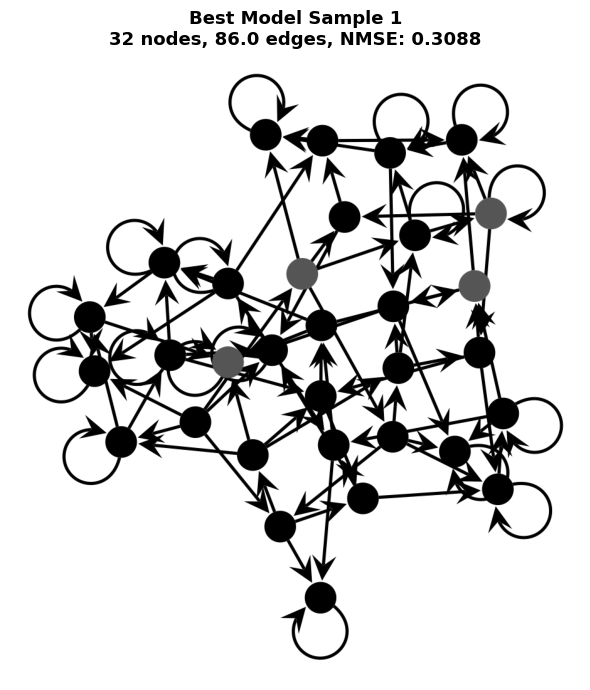

In [13]:
# Visualize multiple reservoirs grown by the best model
n_samples = min(3, len(best_reservoirs))

print(f"Visualizing {n_samples} reservoir(s) from best model...\n")

for i in range(n_samples):
    res = best_reservoirs[i]
    fit = best_fitnesses[i] if i < len(best_fitnesses) else np.nan
    
    print(f"Sample {i+1}:")
    print(f"  Nodes: {res.size()}, Edges: {res.num_edges()}")
    print(f"  Connectivity: {res.connectivity():.4f}, NMSE: {fit:.4f}")
    
    if res.size() > 0:
        try:
            # Save to file then display
            filename = f"best_reservoir_{i}.png"
            res.draw_gt(output=filename, output_size=(500, 500))
            
            # Display the saved image
            img = plt.imread(filename)
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Best Model Sample {i+1}\n{res.size()} nodes, {res.num_edges()} edges, NMSE: {fit:.4f}", 
                        fontsize=13, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Clean up temporary file
            import os
            if os.path.exists(filename):
                os.remove(filename)
        except Exception as e:
            print(f"  Error rendering: {str(e)}")
    else:
        print(f"  Empty graph - nothing to visualize")
    print()

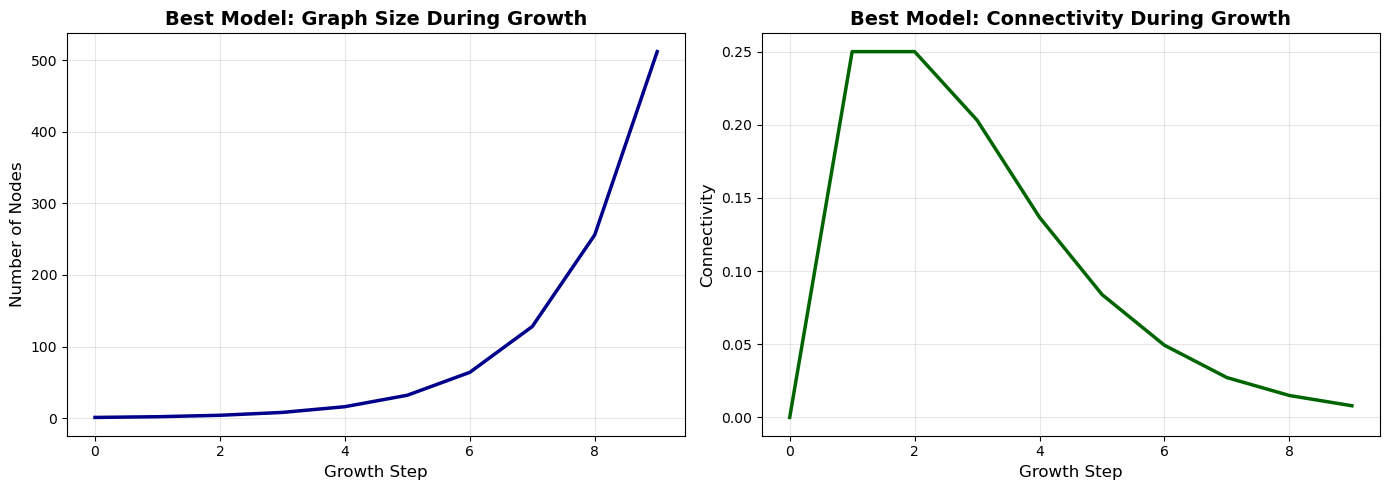


Growth trajectory of best model:
  Final size: 256 nodes
  Final connectivity: 0.0150
  Status: max_size
  Transient: 9, Attractor: 0


In [14]:
# Grow a new reservoir using the best model and watch its growth
if best_model is not None:
    runner_best = Runner(max_steps=100, max_size=300)
    final_best = runner_best.run(best_model, seed_reservoir)
    
    sizes_best = runner_best.graph_size()
    conn_best = runner_best.graph_connectivity()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(sizes_best, linewidth=2.5, color='darkblue')
    ax1.set_xlabel('Growth Step', fontsize=12)
    ax1.set_ylabel('Number of Nodes', fontsize=12)
    ax1.set_title('Best Model: Graph Size During Growth', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(conn_best, linewidth=2.5, color='darkgreen')
    ax2.set_xlabel('Growth Step', fontsize=12)
    ax2.set_ylabel('Connectivity', fontsize=12)
    ax2.set_title('Best Model: Connectivity During Growth', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nGrowth trajectory of best model:")
    print(f"  Final size: {final_best.size()} nodes")
    print(f"  Final connectivity: {final_best.connectivity():.4f}")
    print(f"  Status: {runner_best.status}")
    trans, attr = runner_best.attractor_info()
    print(f"  Transient: {trans}, Attractor: {attr}")

## 6. Parallel Evolutionary Runs

Run multiple evolutionary instances in parallel to find multiple nice solutions faster.

In [37]:
import multiprocessing as mp

def run_evolution(run_id):
    """Run one evolutionary instance."""
    np.random.seed(2050 + run_id) ### Change seed for each run for diversity
    
    model = EvolvableDGCA(n_states=args.n_states, hidden_size=32, noise=args.noise)
    runner = Runner(max_steps=10, max_size=50)
    
    mga = ChromosomalMGA(
        popsize=args.pop_size,
        seed_graph=seed_reservoir,
        model=model,
        runner=runner,
        fitness_fn=fitness_fn,
        mutate_rate=args.mutate_rate,
        cross_rate=args.cross_rate,
        cross_style=args.cross_style,
        run_id=run_id,
        n_trials=args.n_trials,
        output_dir=f"{args.output_dir}/run{run_id}",
        heavy_log=False,
        n_reps_if_noisy=args.n_reps_if_noisy
    )
    
    mga.run(progress=False)
    
    return {
        'run_id': run_id,
        'fitness': mga.best['avg_fitness'],
        'model': mga.best['model'],
        'reservoir': mga.best['reservoirs'][0] if mga.best['reservoirs'] else None
    }

In [38]:
#################################################################
#### PLEASE CONSIDER THE CPU NUMBER OF YOUR MACHINE !!!! ########
#################################################################

# Run 4 evolutionary instances in parallel
### YOU MAY REDUCE INSTANCES FOR FASTER TESTING (especially if your machine has limited CPU cores)
### This took ~ 8 min on my Thinkpad for 16 instances, 11 min for 20, so adjust as needed

n_runs = 16

print(f"Running {n_runs} evolutionary instances in parallel...\n")

with mp.Pool(processes=n_runs) as pool:
    results = pool.map(run_evolution, range(n_runs))

# Find best result
best = min(results, key=lambda x: x['fitness'])

print("\nResults:")
for r in results:
    marker = " ← BEST" if r['run_id'] == best['run_id'] else ""
    print(f"Run {r['run_id']}: NMSE = {r['fitness']:.6f}{marker}")
    
print(f"\nBest: Run {best['run_id']} with NMSE = {best['fitness']:.6f}")

Running 16 evolutionary instances in parallel...

[run 0] Best-of-run results will be stored in: demo_results/run0/best_run_0.json[run 1] Best-of-run results will be stored in: demo_results/run1/best_run_1.json[run 3] Best-of-run results will be stored in: demo_results/run3/best_run_3.json[run 4] Best-of-run results will be stored in: demo_results/run4/best_run_4.json
[run 2] Best-of-run results will be stored in: demo_results/run2/best_run_2.json[run 7] Best-of-run results will be stored in: demo_results/run7/best_run_7.json
[run 5] Best-of-run results will be stored in: demo_results/run5/best_run_5.json[run 8] Best-of-run results will be stored in: demo_results/run8/best_run_8.json
[run 6] Best-of-run results will be stored in: demo_results/run6/best_run_6.json

[run 13] Best-of-run results will be stored in: demo_results/run13/best_run_13.json[run 10] Best-of-run results will be stored in: demo_results/run10/best_run_10.json[run 11] Best-of-run results will be stored in: demo_result

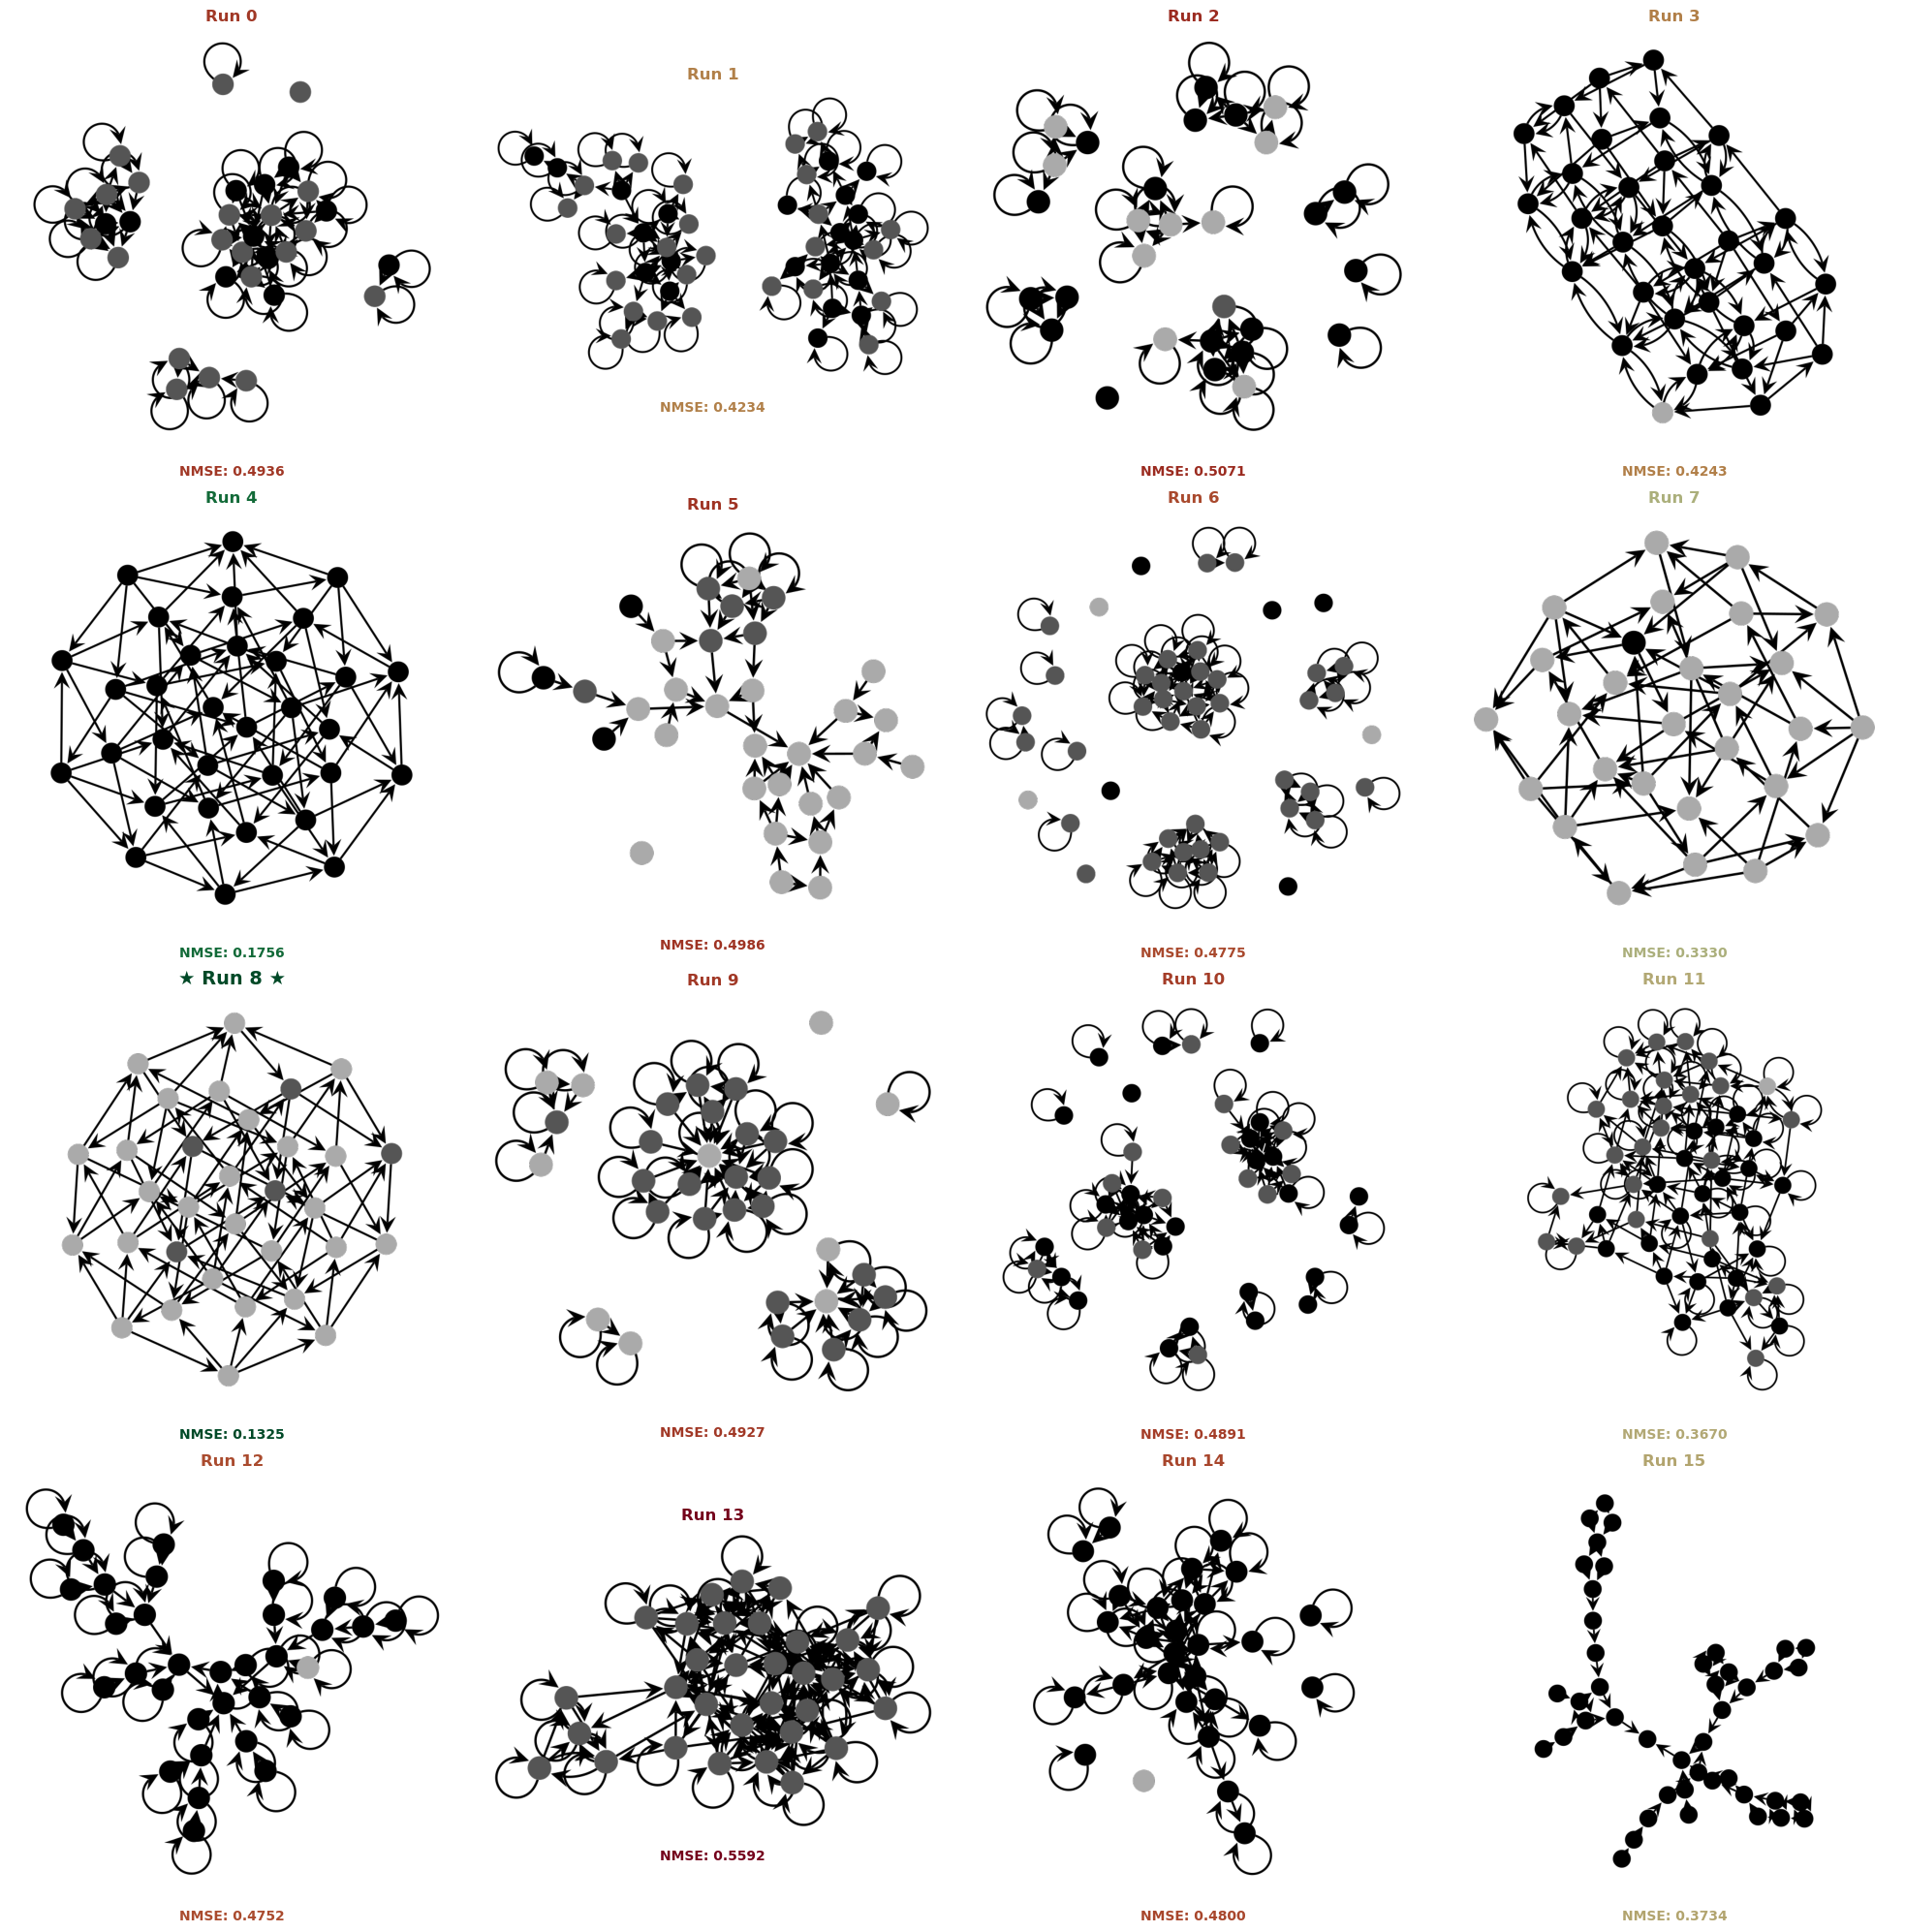

In [44]:
np.random.seed(2040)

# Visualize all results
import math
import os

# Auto-detect grid size (prefer square layout)
n_cols = math.ceil(math.sqrt(n_runs))
n_rows = math.ceil(n_runs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten() if n_runs > 1 else [axes]

# Get fitness range for color mapping
fitnesses = [r['fitness'] for r in results]
min_fitness = min(fitnesses)
max_fitness = max(fitnesses)
fitness_range = max_fitness - min_fitness if max_fitness > min_fitness else 1

for i, r in enumerate(results):
    if r['reservoir'] and r['reservoir'].size() > 0:
        filename = f"run_{r['run_id']}.png"
        r['reservoir'].draw_gt(output=filename, output_size=(400, 400))
        img = plt.imread(filename)
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Color code based on fitness (greener = better/lower NMSE)
        norm_fitness = (r['fitness'] - min_fitness) / fitness_range
        color = plt.cm.RdYlGn_r(norm_fitness)  # Green for best, red for worst
        
        # Convert to RGB and darken to improve visibility on white background
        rgb = np.array(color[:3])
        darkened_rgb = rgb * 0.7  # Darken by 30%
        color = tuple(darkened_rgb) + (1.0,)  # Add alpha channel
        
        title = f"Run {r['run_id']}"
        if r['run_id'] == best['run_id']:
            title = f"★ {title} ★"
        
        axes[i].set_title(title, fontsize=14 if r['run_id'] == best['run_id'] else 12, 
                         fontweight='bold', color=color)
        
        # Add fitness value below the plot
        axes[i].text(0.5, -0.05, f'NMSE: {r["fitness"]:.4f}', 
                    transform=axes[i].transAxes, 
                    ha='center', va='top', fontsize=10, color=color, fontweight='bold')
        
        if os.path.exists(filename):
            os.remove(filename)

# Hide any unused subplots
for i in range(n_runs, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 7. Testing the Best Model from Parallel Runs

Now let's test the best model found across all parallel runs on the NARMA task, just like we did in Section 3.

In [40]:
# Use the best reservoir from parallel runs
# Convert it to bipolar weights for better reservoir computing performance
best_parallel_reservoir = best['reservoir'].bipolar()

print(f"Using best reservoir from parallel runs for NARMA task:")
print(f"  Run ID: {best['run_id']}")
print(f"  Original Fitness: {best['fitness']:.6f}")
print(f"  Size: {best_parallel_reservoir.size()} nodes")
print(f"  Edges: {best_parallel_reservoir.num_edges()}")
print(f"  Connectivity: {best_parallel_reservoir.connectivity():.4f}")
print(f"  Largest component: {best_parallel_reservoir.get_largest_component_frac():.2%}")

Using best reservoir from parallel runs for NARMA task:
  Run ID: 8
  Original Fitness: 0.132484
  Size: 32 nodes
  Edges: 54.0
  Connectivity: 0.0527
  Largest component: 100.00%


NARMA task data generated:
  Input shape: (1, 2000)
  Target shape: (1, 2000)

Training complete!
NMSE (lower is better): 0.1391

Training complete!
NMSE (lower is better): 0.1391


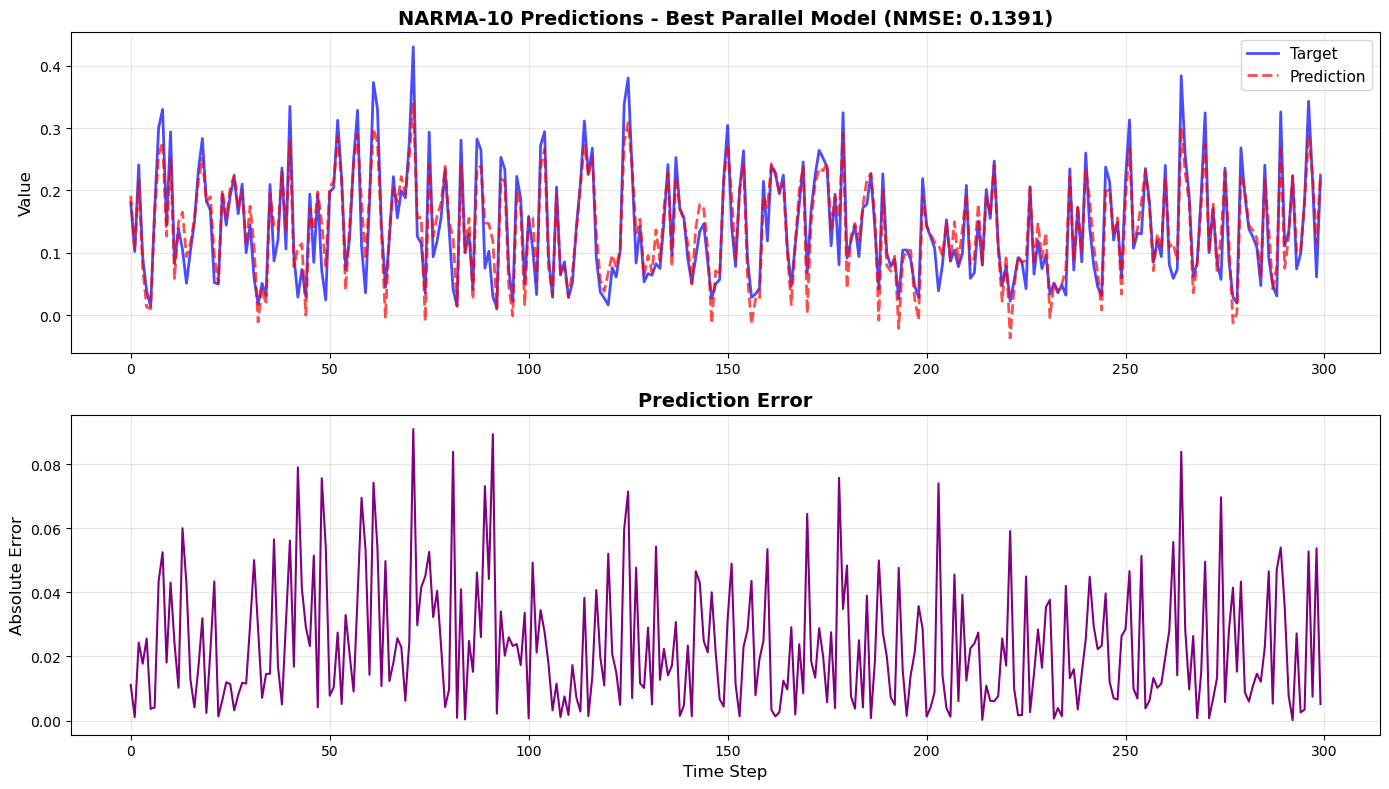

In [41]:
# Generate NARMA-10 task data
input_seq, target_seq = narmax(order=10, num_timesteps=2000)

print(f"NARMA task data generated:")
print(f"  Input shape: {input_seq.shape}")
print(f"  Target shape: {target_seq.shape}")

# Train the best reservoir on the NARMA task
best_parallel_reservoir.reset()
predictions = best_parallel_reservoir.train(input_seq, target=target_seq)

# Calculate NMSE (Normalized Mean Squared Error)
washout = best_parallel_reservoir.washout
nmse = np.mean((target_seq[:, washout:] - predictions) ** 2) / np.var(target_seq[:, washout:])

print(f"\nTraining complete!")
print(f"NMSE (lower is better): {nmse:.4f}")

# Visualize predictions vs targets
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

time_window = 300
start_idx = washout
end_idx = start_idx + time_window

# Plot predictions vs target
ax1.plot(target_seq[0, start_idx:end_idx], linewidth=2, label='Target', color='blue', alpha=0.7)
ax1.plot(predictions[0, :time_window], linewidth=2, label='Prediction', color='red', alpha=0.7, linestyle='--')
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title(f'NARMA-10 Predictions - Best Parallel Model (NMSE: {nmse:.4f})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot error over time
error = np.abs(target_seq[0, start_idx:end_idx] - predictions[0, :time_window])
ax2.plot(error, linewidth=1.5, color='purple')
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Prediction Error', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()